# Analysing german news articles

## Imports

In [2]:
# Pandas is an open source data analysis and manipulation tool
import pandas as pd
from pandas import json_normalize 

# os gives access to the operating system
import os
# The datetime module supplies classes for manipulating dates and times.
from datetime import datetime 
import datetime
# This module provides various time-related functions.
import time

# Natural language toolkit
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# library to create visualizations
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.offsetbox import AnchoredText


# open source library for automating downloading of reports from Google Trends
from pytrends.request import TrendReq

# library to get html of website (wikipedia)
import requests
# json to use wikipedia return
import json




## Load data into DataFrames

In [72]:
# Folderpath to CSV's
CSV_folderPath="/Users/jan/Documents/Python_Projects/Bachelorthesis/CSV_Backlog"

# Initialize list<csv> for Spiegel, Sueddeutsche, Bild and combined 
Spiegel_csvs = []
Sueddeutsche_csvs = []
Bild_csvs = []
Combi_csvs = []


# Change directory to CSV_folderPath
os.chdir(CSV_folderPath)

# iterate over all files
for file in os.listdir():
    # that are csvs...
    if file.endswith(".csv"):        
        # read csv to dataframe
        df =pd.read_csv(file, index_col=None, header=0)
        # all df append to combi...
        Combi_csvs.append(df)
        # sort dataframe to its list
        #Spiegel
        if file.startswith("Spiegel"):
            Spiegel_csvs.append(df)
        # Sueddeutsche
        elif file.startswith("Sueddeutsche"):
            Sueddeutsche_csvs.append(df)
        # Bild
        elif file.startswith("Bild"):
            Bild_csvs.append(df)
    
All_articles = pd.concat(Combi_csvs, axis=0, ignore_index=True)
Spiegel_articles = pd.concat(Spiegel_csvs, axis=0, ignore_index=True)
Sueddeutsche_articles = pd.concat(Sueddeutsche_csvs, axis=0, ignore_index=True)
if(len(Bild_csvs)) != 0:
    Bild_articles = pd.concat(Bild_csvs, axis=0, ignore_index=True)
else:
    Bild_articles=[]

    
# Drop duplicates

# All articles
All_articles= All_articles.drop_duplicates(subset="Titel")

# Spiegel articles
Spiegel_articles = Spiegel_articles.drop_duplicates(subset="Titel")

# Sueddeutsch articles
Sueddeutsche_articles = Sueddeutsche_articles.drop_duplicates(subset="Titel")

# Bild articles
#Bild_articles = Bild_articles.drop_duplicates(subset="title")
All_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91148 entries, 0 to 217471
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Titel                  91148 non-null  object 
 1   Date_Info              91148 non-null  object 
 2   URL                    91148 non-null  object 
 3   Overline               71332 non-null  object 
 4   Breadcrumb             50182 non-null  object 
 5   author                 13980 non-null  object 
 6   detailed_informations  19823 non-null  object 
 7   Zugriff_Datum          73429 non-null  float64
 8   News_page              91148 non-null  object 
 9   Kategorie              17719 non-null  object 
dtypes: float64(1), object(9)
memory usage: 7.6+ MB


## Data Cleaning

### Cast Date_Info to datetime

In [73]:
# All articles
All_articles["Date_Info"] = All_articles["Date_Info"].str.strip()
All_articles["Date_Info"] = pd.to_datetime(All_articles["Date_Info"], format='%d%m%Y_%H:%M')
# Spiegel articles
Spiegel_articles["Date_Info"] = Spiegel_articles["Date_Info"].str.strip()
Spiegel_articles["Date_Info"] = pd.to_datetime(Spiegel_articles["Date_Info"], format='%d%m%Y_%H:%M')
# Sueddeutsche articles
Sueddeutsche_articles["Date_Info"] = Sueddeutsche_articles["Date_Info"].str.strip()
Sueddeutsche_articles["Date_Info"] = pd.to_datetime(Sueddeutsche_articles["Date_Info"], format='%d%m%Y_%H:%M')
# Bild articles
#Bild_carticles["Date_Info"] = pd.to_datetime(Bild_carticles["Date_Info"], format='%d%m%Y_%H:%M')

## Lower category column

In [80]:
All_articles["Kategorie"] = All_articles["Kategorie"].str.lower()

## Initial data analysis

### Ammount of articles

In [74]:
# Spiegel articles
ammount_of_Spiegel_articles = len(Spiegel_articles)
print(f"Spiegel articles: {ammount_of_Spiegel_articles}")

# Sueddeutsche articles
ammount_of_Sueddeutsche_articles = len(Sueddeutsche_articles)
print(f"Sueddeutsche articles: {ammount_of_Sueddeutsche_articles}")

# Bild articles
ammount_of_Bild_articles = len(Bild_articles)
print(f"Bild articles: {ammount_of_Bild_articles}")

# All articles
ammount_of_Combined_articles = len(All_articles)
print(f"Overall: {ammount_of_Combined_articles}")

Spiegel articles: 17719
Sueddeutsche articles: 73431
Bild articles: 0
Overall: 91148


# Helper

### Exploding titles

In [6]:
def explode_titles(title_column):
    title_column =title_column.to_frame()
    tokenized_titles=[]
    title_column["tokenized_title"] = ""
    for index, row in title_column.iterrows():
        # tokenize
        tokenized_title = word_tokenize(row.Titel)
        
        # remove stopwords & numbers/punction
        tokenized_title = [word for word in tokenized_title if word not in stopwords.words("german")]
        
        # add to row
        row.tokenized_title = tokenized_title
        
    return title_column

def make_chunks(data, chunk_size): 
    while data:
        chunk, data = data[:chunk_size], data[chunk_size:]
        yield chunk
        
def normalize_column_by_keyword(dataframe, keyword_list, column):
    dataframe_list = []
    new_column_name = "normalized_" + column
    for keyword in keyword_list:
        working_df = dataframe[dataframe['KeyWord'] == keyword]
        max_occurence = working_df[column].max()
        print(max_occurence)
        df_copy = working_df.copy()
        df_copy[new_column_name] = working_df[column] /working_df[column].abs().max()
        dataframe_list.append(df_copy)
    return pd.concat(dataframe_list)

# Google

In [ ]:
# code snippets
# Connect to Google
pytrends = TrendReq(hl='de-DE', tz='60',timeout=61)

# Build payload
pytrends.build_payload("Andreas Scheuer", cat=0, timeframe="2021-11-07 2022-06-30")

# Get interest over time
data = pytrends.interest_over_time()

In [13]:
error_keyWords_google_trends = []
def get_google_interest_over_time(keyword_list):
    # connect to google
    pytrends = TrendReq(hl='de-DE', tz='60',timeout=61) 

    # keywords
    keywords = keyword_list

    # build payload
    startDate = "2021-11-07"
    dateTime=datetime.datetime.now()
    currentDate = dateTime.strftime("%Y-%m-%d")
    timeframe = startDate +" "+ str(currentDate)
    dataframes = []
    for keyword in keywords:
        keyword_list = []
        keyword_list.append(keyword)
        pytrends.build_payload(keyword_list, cat=0, timeframe= str(timeframe) ) 
        
        # get data with interest over time
        try:
            data = pytrends.interest_over_time() 
            dataframes.append(data)
        except:
            print(keyword)
            error_keyWords_google_trends.append(keyword)
        time.sleep(1.5)
    
    # concat all google trends results
    dfs = pd.concat(dataframes, axis=1)
    # remove deprecated column
    dfs=dfs.loc[:,~dfs.columns.str.startswith('isPartial')]

    # get df to right format
    google_df = dfs.unstack().reset_index() 
    google_df = google_df.rename(columns={"level_0" : "KeyWord", 0 : "Occurence_in_Google"})
    
    #fill all NaN with 0
    google_df["Occurence_in_Google"] = google_df["Occurence_in_Google"].fillna(0)
    google_df["Occurence_in_Google"] = google_df["Occurence_in_Google"].astype(int)
    
    google_df["normalized_Occurence_in_Google"] = google_df["Occurence_in_Google"].div(100)
    return google_df

# Wikipedia

In [ ]:
# Example Codesnippets
user_agent = {'user-agent': 'Influence_of_daily_political_news_on_the_use_of_wikipedia/1.0 (jan.schuckatt-online.de)'}
url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/de.wikipedia.org/all-access/all-agents/Andreas_Scheuer/daily/20220620/20220622"
response = requests.get(url, headers=user_agent)



In [8]:
def get_wikipedia_interest_over_time(keyword_list):
    dateTime=datetime.datetime.now()
    currentDate = dateTime.strftime("%Y%m%d")
    return_list=[]
    # chunk keywords due to wikimedia policy
    for chunk in make_chunks(keyword_list, 200):        
        for keyword in chunk:
            headers = {'user-agent': 'Influence_of_daily_political_news_on_the_use_of_wikipedia/1.0 (jan.schuckatt-online.de)'}
            url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/de.wikipedia.org/all-access/all-agents/{keyword}/daily/20211107/{currentDate}"
            r = requests.get(url, headers=headers)
            return_list.append(r.text)
        time.sleep(5)
    # deserialize json   
    json_dict=[]
    for wiki_dict in return_list:
        data = json.loads(wiki_dict)
        json_dict.append(data)
        
    #json to dataframe
    lst_of_df=[]
    for counter in range(len(json_dict)):
        try:
            lst_of_df.append(pd.DataFrame.from_records(json_dict[counter]["items"]))
        except:
            print(json_dict[counter])
    wikipedia_DF = pd.concat(lst_of_df)
    
    wikipedia_DF = wikipedia_DF.rename(columns={"article" : "KeyWord", "views" : "Occurence_in_Wikipedia", "timestamp" : "date"})
    
    wikipedia_DF = setCorrectDataTypes_wikipedia(wikipedia_DF)
    wikipedia_DF = wikipedia_DF[["KeyWord", "date", "Occurence_in_Wikipedia"]]
    wikipedia_DF = normalize_column_by_keyword(wikipedia_DF,keyword_list,"Occurence_in_Wikipedia")
    return wikipedia_DF

# set set datetime format
def setCorrectDataTypes_wikipedia(dataframe):
    dataframe["date"] = pd.to_datetime(dataframe["date"], format='%Y%m%d%H')
    return dataframe




# get cccurence of titles 

In [9]:
def get_occurence_of_all_titles(data_frame, columnName):
    # Group titles by columnName
    all_titles = data_frame.groupby(columnName).size()
    
    #sort titles
    all_titles = all_titles.sort_values(ascending = False)
    
    return all_titles

def get_occurence_of_all_capital_titles(data_frame, columnName):
    all_titles=data_frame.groupby(columnName).size()

    capital_titles=[]
    counter=0
    for title in all_titles.items():
        title_s=str(title)
        title_s=title_s.strip()
        if title_s.istitle():
            capital_titles.append(title)        
    Titles = pd.DataFrame.from_records(
    capital_titles, columns=['Title','Occurence'])
    return Titles.sort_values(by=['Occurence'],ascending=False)

def get_titles_with_minimum_occurence_N(data_frame, N):
    all_Titles = get_occurence_of_all_capital_titles(data_frame, "tokenized_titles")
    above_N = []
    for index,row in all_Titles.iterrows():
        if int(row.Occurence) >= N:
            above_N.append(row)
            
    above_N = pd.DataFrame(above_N, columns=['Title', 'Occurence'])

    return data_frame[data_frame["tokenized_titles"].isin(above_N.Title)]

def get_titles_with_minimum_occurence_N(data_frame, N):
    all_Titles = get_occurence_of_all_capital_titles(data_frame, "tokenized_titles")
    above_N = []
    for index,row in all_Titles.iterrows():
        if int(row.Occurence) >= N:
            above_N.append(row)
            
    above_N = pd.DataFrame(above_N, columns=['Title', 'Occurence'])

    return data_frame[data_frame["tokenized_titles"].isin(above_N.Title)]        

# Build exploded DataFrame

In [91]:
All_articles["tokenized_titles"] = explode_titles(All_articles["Titel"]).tokenized_title
All_articles_exploded = All_articles.explode("tokenized_titles")
uninteresting_titles= ["Der", "Die", "Das","Was","Warum","Er","Sie", "Es", "Ich", "Du", "Mit","Wie","Ein","So","Wir",
                       ":","»","«", "," ,"\'\'","``", "_","-" ".","?","–", "-",".","!"]

All_articles_exploded=All_articles_exploded[~All_articles_exploded.tokenized_titles.isin(uninteresting_titles)]

All_articles_exploded = get_sueddeutsche_category(All_articles_exploded)

All_articles = get_sueddeutsche_category(All_articles)


def get_sueddeutsche_category(df):
    mask = df['News_page'] == 'Sueddeutsche'
    df.loc[mask, 'Kategorie'] = df.loc[mask, 'URL'].apply(lambda x: x.split('/')[3])
    
    merging_categories = {
    "digital" :"netzwelt",
    "wissen"  :"wissenschaft",
    "leben"   :"Entertainment",
    "chancen" : "Entertainment",
    "Service" : "Entertainment",
    "meinung" : "Entertainment",
    "bayern"  : "bayern & muenchen",
    "muenchen": "bayern & muenchen"
    }
    df["Kategorie"].replace(merging_categories, inplace=True)

    return df

## Analysis

### Ammount of articles with occurence above n

In [37]:
occurence = [10,25,50,75,100,125,150,200,300,350,400,450,500]
for n in occurence:
    x = get_titles_with_minimum_occurence_N(All_articles_exploded, n)
    y = get_occurence_of_all_capital_titles(x,"tokenized_titles")
    print("n:"+str(n) +" = "+str(len(y)))

n:10 = 4933
n:25 = 1942
n:50 = 881
n:75 = 558
n:100 = 379
n:125 = 272
n:150 = 209
n:200 = 132
n:300 = 72
n:350 = 48
n:400 = 42
n:450 = 35
n:500 = 25


# Build Occurence DF with Wikipedia and Google

In [19]:
def build_Occurence_df(dataframe, n_occurences):
    article_over_occurence = get_titles_with_minimum_occurence_N(dataframe[["Date_Info", "tokenized_titles","Kategorie"]], n_occurences)

    # prep keyword list "Titles"
    keyword_list = list(article_over_occurence["tokenized_titles"].drop_duplicates())
    # get google data
    google_data = get_google_interest_over_time(keyword_list)
    # get wikipedia data
    wikipedia_data = get_wikipedia_interest_over_time(keyword_list)

    #rename columns
    article_over_occurence = article_over_occurence.rename(columns={"Date_Info" : "date", "tokenized_titles" : "Occurence_in_news"})
    #convert to datetime
    article_over_occurence['date'] = pd.to_datetime(article_over_occurence.date) 
    #convert datetime format to googles datetime format
    article_over_occurence['date'] = article_over_occurence['date'].dt.strftime('%Y-%m-%d')
    #reshape our data frame to look like google data frame
    occurence_df=article_over_occurence.pivot_table(index='date', columns='Occurence_in_news', aggfunc='size') \
                .rename_axis(None, axis=1)
    #fill all NaN with 0
    occurence_df = occurence_df.fillna(0)
    occurence_df = occurence_df.astype(int)

    # bring news df to right format
    news_df = occurence_df.unstack().reset_index()
    news_df = news_df.rename(columns={"level_0" : "KeyWord", 0 : "Occurence_in_News"})
    news_df["date"]=pd.to_datetime(news_df["date"], format='%Y-%m-%d')
    news_df = normalize_column_by_keyword(news_df,keyword_list,"Occurence_in_News")
        
    # merge google and news
    #full_df = pd.merge(news_df, google_data, on=['KeyWord',"date"], how='outer')
    
    full_df = pd.merge(pd.merge(news_df,google_data,on=['KeyWord',"date"]),wikipedia_data,on=['KeyWord',"date"])

    
    #fill all NaN with 0
    full_df["Occurence_in_Google"] = full_df["Occurence_in_Google"].fillna(0)
    full_df["Occurence_in_Google"] = full_df["Occurence_in_Google"].astype(int)
    return full_df
    
    

In [42]:
All_articles

,Titel,Date_Info,URL,Overline,Breadcrumb,author,detailed_informations,Zugriff_Datum,News_page,Kategorie,tokenized_titles
0,Gasspeicher wenig gefüllt: Ist die Versorgung ...,2022-01-21 09:00:00,https://www.sueddeutsche.de/wirtschaft/gas-gas...,Gas,dpa,NaN,NaN,21012022.0,Sueddeutsche,NaN,Gasspeicher
0,Gasspeicher wenig gefüllt: Ist die Versorgung ...,2022-01-21 09:00:00,https://www.sueddeutsche.de/wirtschaft/gas-gas...,Gas,dpa,NaN,NaN,21012022.0,Sueddeutsche,NaN,wenig
0,Gasspeicher wenig gefüllt: Ist die Versorgung ...,2022-01-21 09:00:00,https://www.sueddeutsche.de/wirtschaft/gas-gas...,Gas,dpa,NaN,NaN,21012022.0,Sueddeutsche,NaN,gefüllt
0,Gasspeicher wenig gefüllt: Ist die Versorgung ...,2022-01-21 09:00:00,https://www.sueddeutsche.de/wirtschaft/gas-gas...,Gas,dpa,NaN,NaN,21012022.0,Sueddeutsche,NaN,Ist
0,Gasspeicher wenig gefüllt: Ist die Versorgung ...,2022-01-21 09:00:00,https://www.sueddeutsche.de/wirtschaft/gas-gas...,Gas,dpa,NaN,NaN,21012022.0,Sueddeutsche,NaN,Versorgung
...,...,...,...,...,...,...,...,...,...,...,...
217471,Regierung streicht fast 20 Länder von Risikoliste,2022-02-18 13:04:00,https://www.sueddeutsche.de/politik/corona-akt...,Meldungen zum Coronavirus,NaN,Nachrichten aus Deutschland und aller Welt,Von Sonntag an gelten unter anderem Großbritan...,18022022.0,Sueddeutsche,NaN,streicht
217471,Regierung streicht fast 20 Länder von Risikoliste,2022-02-18 13:04:00,https://www.sueddeutsche.de/politik/corona-akt...,Meldungen zum Coronavirus,NaN,Nachrichten aus Deutschland und aller Welt,Von Sonntag an gelten unter anderem Großbritan...,18022022.0,Sueddeutsche,NaN,fast
217471,Regierung streicht fast 20 Länder von Risikoliste,2022-02-18 13:04:00,https://www.sueddeutsche.de/politik/corona-akt...,Meldungen zum Coronavirus,NaN,Nachrichten aus Deutschland und aller Welt,Von Sonntag an gelten unter anderem Großbritan...,18022022.0,Sueddeutsche,NaN,20
217471,Regierung streicht fast 20 Länder von Risikoliste,2022-02-18 13:04:00,https://www.sueddeutsche.de/politik/corona-akt...,Meldungen zum Coronavirus,NaN,Nachrichten aus Deutschland und aller Welt,Von Sonntag an gelten unter anderem Großbritan...,18022022.0,Sueddeutsche,NaN,Länder


In [15]:
df=build_Occurence_df(All_articles_exploded,50)




Corona-Lockerungen
{'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found', 'title': 'Not found.', 'method': 'get', 'detail': 'The date(s) you used are valid, but we either do not have data for those date(s), or the project you asked for is not loaded yet.  Please check https://wikimedia.org/api/rest_v1/?doc for more information.', 'uri': '/analytics.wikimedia.org/v1/pageviews/per-article/de.wikipedia.org/all-access/all-agents/Mehrere/daily/20211107/20220411'}
{'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found', 'title': 'Not found.', 'method': 'get', 'detail': 'The date(s) you used are valid, but we either do not have data for those date(s), or the project you asked for is not loaded yet.  Please check https://wikimedia.org/api/rest_v1/?doc for more information.', 'uri': '/analytics.wikimedia.org/v1/pageviews/per-article/de.wikipedia.org/all-access/all-agents/Unf%C3%A4lle/daily/20211107/20220411'}
{'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_fo

In [12]:
def createFigure(data_frame, fileName):
    plot = data_frame.plot.line(x="date",y=[1,2],figsize=(20,10), title="Occurence of "+fileName)
    Correlation = data_frame["News_Data"].corr(data_frame["Google_Data"])
    plot.annotate("Correlation: " + str(Correlation) , xy=(0.05, 0.95), xycoords='axes fraction')    
    return plot.get_figure()



## Plots

### Plot occurence of top 50 titles

<AxesSubplot:xlabel='tokenized_titles'>

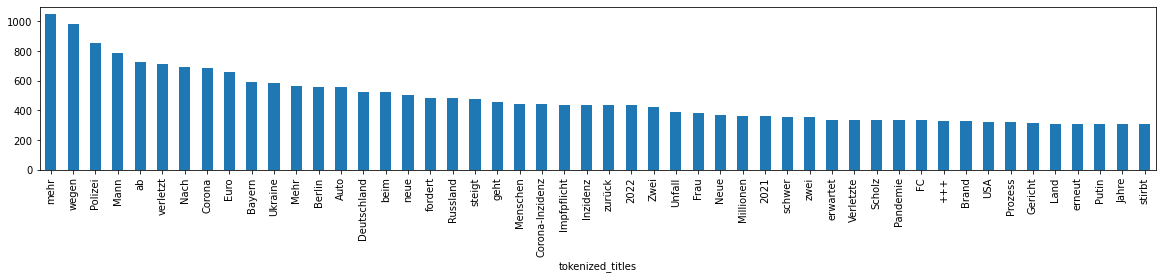

In [54]:
# get all titles
all_titles = get_occurence_of_all_titles(All_articles_exploded,"tokenized_titles")

# get top 50
top50_titles = all_titles[:50]

plt.figure(figsize=(20,3))
top50_titles.plot(kind="bar")

### Plot occurence of top 50 titles starting with capital letter

<AxesSubplot:xlabel='Title'>

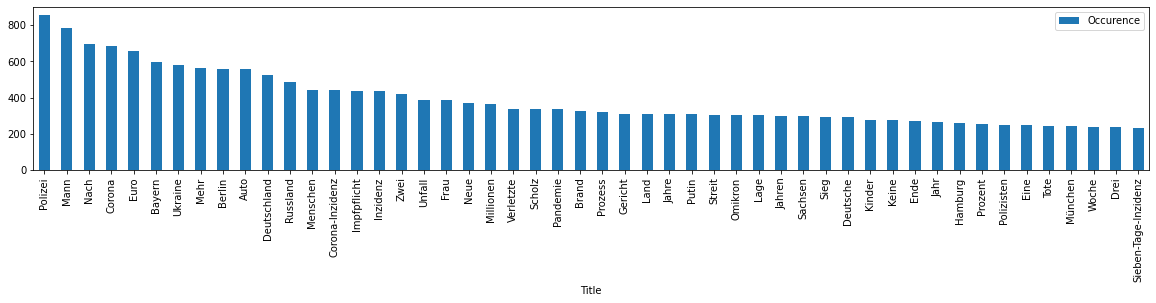

In [55]:
# get all titles
all_titles = get_occurence_of_all_capital_titles(All_articles_exploded,"tokenized_titles")

#get top 50
top50_titles = all_titles[:50]

#plot
top50_titles.plot.bar(x="Title",y="Occurence",figsize=(20, 3))


In [44]:
def saveCSV(dataframe, filename):
    dataframe.to_csv("/Users/jan/Documents/Python_Projects/Bachelorthesis/Analysis/DataFrames/"+ filename +".csv",index=False)


In [90]:
saveCSV(All_articles,"unexploded_dataframe_11_04_22")

In [92]:
All_articles

,Titel,Date_Info,URL,Overline,Breadcrumb,author,detailed_informations,Zugriff_Datum,News_page,Kategorie,tokenized_titles
0,Gasspeicher wenig gefüllt: Ist die Versorgung ...,2022-01-21 09:00:00,https://www.sueddeutsche.de/wirtschaft/gas-gas...,Gas,dpa,NaN,NaN,21012022.0,Sueddeutsche,wirtschaft,"[Gasspeicher, wenig, gefüllt, :, Ist, Versorgu..."
1,Mann auf Autobahnparkplatz mutmaßlich erstochen,2022-01-21 09:00:00,https://www.sueddeutsche.de/panorama/kriminali...,Kriminalität - Hoort,dpa,NaN,NaN,21012022.0,Sueddeutsche,panorama,"[Mann, Autobahnparkplatz, mutmaßlich, erstochen]"
2,Sag beim Abstieg leise Service,2022-01-21 09:00:00,https://www.sueddeutsche.de/panorama/mitten-in...,"SZ-Kolumne ""Mitten in ...""",NaN,"Von Thomas Balbierer, Max Fluder und Karin Janker",Wenn ein dänischer Tourist in den bayerischen ...,21012022.0,Sueddeutsche,panorama,"[Sag, beim, Abstieg, leise, Service]"
3,Ein Imam unter Verdacht,2022-01-21 08:58:00,https://www.sueddeutsche.de/politik/belgien-mo...,Molenbeek,NaN,"Von Josef Kelnberger, Brüssel",Belgien entzieht einem der bekanntesten muslim...,21012022.0,Sueddeutsche,politik,"[Ein, Imam, Verdacht]"
4,Schnee und Eis: Mehrere Unfälle wegen glatter ...,2022-01-21 08:58:00,https://www.sueddeutsche.de/panorama/schnee-un...,NaN,NaN,NaN,Video\n \n ...,21012022.0,Sueddeutsche,panorama,"[Schnee, Eis, :, Mehrere, Unfälle, wegen, glat..."
...,...,...,...,...,...,...,...,...,...,...,...
217439,Wir sehen uns vor Gericht,2022-04-06 05:10:00,https://www.sueddeutsche.de/sport/fc-bayern-we...,Wechselfehler des FC Bayern,NaN,Von Johannes Aumüller und Christof Kneer,Nach dem offiziellen Einspruch gegen die Spiel...,6042022.0,Sueddeutsche,sport,"[Wir, sehen, Gericht]"
217440,Schauer und teils Sturm in Hessen,2022-04-06 05:05:00,https://www.sueddeutsche.de/panorama/wetter-of...,Wetter - Offenbach am Main,dpa,NaN,NaN,6042022.0,Sueddeutsche,panorama,"[Schauer, teils, Sturm, Hessen]"
217442,Polnischer Vizeaußenminister: Scholz sollte na...,2022-04-06 04:49:00,https://www.sueddeutsche.de/politik/konflikte-...,Konflikte,dpa,NaN,NaN,6042022.0,Sueddeutsche,politik,"[Polnischer, Vizeaußenminister, :, Scholz, Kie..."
217447,Frau wird festgenommen wegen Skidiebstahls in ...,2022-02-18 13:17:00,https://www.sueddeutsche.de/bayern/kriminalita...,Kriminalität - Ischgl,dpa,NaN,NaN,18022022.0,Sueddeutsche,bayern & muenchen,"[Frau, festgenommen, wegen, Skidiebstahls, gro..."
